In [479]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
import torch.nn.functional as F

In [484]:
training_set = pd.read_csv('train_ts_top5.csv', index_col='item_id')

In [485]:
training_set

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,115,104,107,81,73,62,71,75,83,93
FOODS_1_012,0,0,0,0,0,0,0,0,0,0,...,65,55,43,46,43,36,53,57,61,56
FOODS_1_018,47,26,30,24,13,18,30,32,31,16,...,104,134,146,98,92,71,99,100,128,105
FOODS_1_032,62,63,34,54,48,45,49,42,31,25,...,100,98,71,71,62,52,75,72,89,83
FOODS_1_043,0,0,0,0,0,0,0,0,0,0,...,186,109,139,104,68,54,101,115,104,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_1_447,0,0,0,0,0,0,0,0,0,0,...,81,85,62,76,76,56,47,77,62,34
HOUSEHOLD_1_459,0,0,0,0,0,0,0,0,0,0,...,92,149,85,84,90,89,88,119,122,100
HOUSEHOLD_1_465,0,0,0,0,0,0,0,0,0,0,...,110,139,157,106,61,62,78,108,99,91


In [486]:
training_set = pd.DataFrame(training_set.iloc[0, :])

#training_set['lag_1'] = training_set.shift()

training_set = training_set.diff(7).dropna()

In [487]:
training_set.values

array([[  0.],
       [  0.],
       [  0.],
       ...,
       [-40.],
       [-21.],
       [-14.]])

In [460]:
#training_set = training_set.T.values.reshape(len(training_set), 2)

In [461]:
#training_set

In [489]:
train = training_set[:int(0.8 * len(training_set))]
valid = training_set[int(0.8 * len(training_set)):int(0.9 * len(training_set))]
test = training_set[int(0.9 * len(training_set)):]

In [493]:
indexer = np.arange(len(training_set))

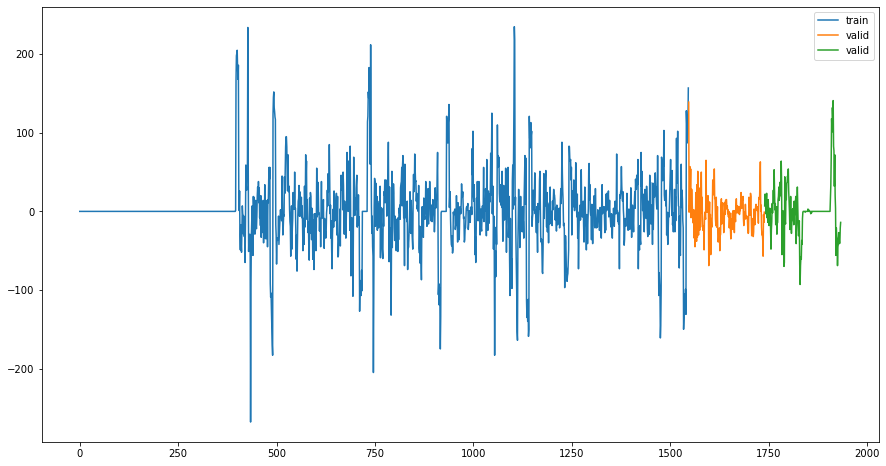

In [497]:
plt.figure(figsize=(15, 8))

plt.plot(
    indexer[:int(0.8 * len(training_set))],
    train,
    label='train'
)

plt.plot(
    indexer[int(0.8 * len(training_set)):int(0.9 * len(training_set))],
    valid,
    label='valid'
)


plt.plot(
    indexer[int(0.9 * len(training_set)):],
    test,
    label='valid'
)

plt.legend()
plt.show()

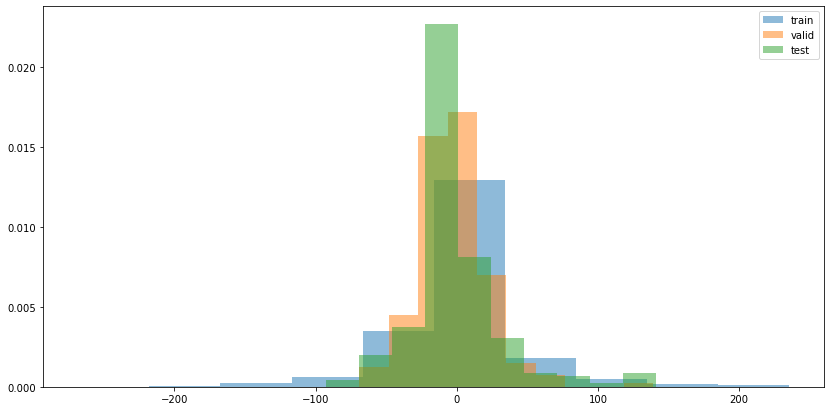

In [503]:
plt.figure(figsize=(14, 7))

plt.hist(
    train,
    density=True,
    label='train',
    alpha=0.5
)

plt.hist(
    valid,
    density=True,
    label='valid',
    alpha=0.5
)

plt.hist(
    test,
    density=True,
    label='test',
    alpha=0.5
)

plt.legend()
plt.show()

In [504]:
def sliding_windows(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1-pred_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+pred_length+seq_length] 
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler((-1,1))

train = sc.fit_transform(train)
valid = sc.transform(valid)

seq_length = 90
pred_length = 28
x_train, y_train = sliding_windows(train, seq_length, pred_length)
x_valid, y_valid = sliding_windows(valid, seq_length, pred_length)


TrainX = Variable(torch.Tensor(np.array(x_train)))
Trainy = Variable(torch.Tensor(np.array(y_train)))
ValidX = Variable(torch.Tensor(np.array(x_valid)))
Validy = Variable(torch.Tensor(np.array(y_valid)))

In [505]:
TrainX.shape, Trainy.shape

(torch.Size([1428, 90, 1]), torch.Size([1428, 28, 1]))

## Encoder 

In [506]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return x, hidden , cell 

## Decoder 

In [507]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim ) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
       
        hidden = hidden[2:3,:,:]
        
        #print("hidden size is",hidden.size())
        
        
        
        #repeat decoder hidden state src_len times
        #hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        hidden = hidden.repeat(1, src_len, 1)
     
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #print("encode_outputs size after permute is:",encoder_outputs.size())
        
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        
        return F.softmax(attention, dim=1)

In [508]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=1,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
        x = x.reshape((1,1,1))
     

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

In [509]:
class AttentionDecoder(nn.Module):
    def __init__(self, seq_len,attention, input_dim=64, n_features=1,encoder_hidden_state = 512):
        super(AttentionDecoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        self.attention = attention 
        
        self.rnn1 = nn.LSTM(
          #input_size=1,
          input_size= encoder_hidden_state + 1,  # Encoder Hidden State + One Previous input
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim * 2 , n_features)

    def forward(self, x,input_hidden,input_cell,encoder_outputs):
       
        a = self.attention(input_hidden, encoder_outputs)
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
      
        
        weighted = torch.bmm(a, encoder_outputs)
        
        
     
        x = x.reshape((1,1,1))
       
        
        
        rnn_input = torch.cat((x, weighted), dim = 2)
       

        #x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
        x, (hidden_n, cell_n) = self.rnn1(rnn_input,(input_hidden,input_cell))
        
        output = x.squeeze(0)
        weighted = weighted.squeeze(0)
        
        x = self.output_layer(torch.cat((output, weighted), dim = 1))
        return x, hidden_n, cell_n

## Seq2seq

In [510]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length =28):
        super(Seq2Seq, self).__init__()

        
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.attention = Attention(512,512)
        self.output_length = output_length
        self.decoder = AttentionDecoder(seq_len, self.attention, embedding_dim, n_features)
        

    def forward(self,x, prev_y):
        
        encoder_output,hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_output = prev_y
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
        
            prev_x,prev_hidden,prev_cell = self.decoder(prev_output,hidden,cell,encoder_output)
            hidden,cell = prev_hidden,prev_cell
            prev_output = prev_x
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

## Train model

In [511]:
n_features = 1
model = Seq2Seq(seq_length, n_features, 512)

model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [512]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [513]:
from tqdm import tqdm

In [515]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5 ,min_lr=1e-7, eps=1e-08)

n_epochs = 50

history = dict(train=[], val=[])

for epoch in range(n_epochs):
    model.train(True)

    train_losses = []
    for i in tqdm(range(len(TrainX))):
        seq_inp = TrainX[i,:,:]
        seq_true = Trainy[i,:,:]

        optimizer.zero_grad()

        #print(f'prev_y {seq_inp[seq_length-1:seq_length,:]}')
        seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])

        #print(seq_pred, train_y)
        
        loss = criterion(seq_pred, seq_true)
        
        #print(loss.item())
        

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_losses.append(loss.item())
  

    val_losses = []
    model = model.eval()
    with torch.no_grad():
        for i in range(len(ValidX)):
            seq_inp = ValidX[i,:,:]
            seq_true = Validy[i,:,:]


            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])

           
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    #if val_loss < best_loss:
    #    best_loss = val_loss
    #    torch.save(model.state_dict(), 'best_model_n_features.pt')
    #    print("saved best model epoch:",epoch,"val loss is:",val_loss)

    #print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    
    clear_output(True)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(history['train'], label='train loss')
    plt.plot(history['val'], label='val loss')

    plt.legend()
    plt.show()
    
    scheduler.step(val_loss)

  6%|██████▎                                                                                                          | 80/1428 [01:32<25:52,  1.15s/it]


KeyboardInterrupt: 

In [469]:
model = model.eval()

In [470]:
preds = []

for i in range(len(TrainX)):
    seq_inp = TrainX[i,:,:]
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:]).detach().numpy()
    
    preds.append(seq_pred)

In [471]:
predy = np.array(preds)
predy.shape

(1428, 28, 1)

In [472]:
valy = Trainy.detach().numpy()
valy.shape

(1428, 28, 1)

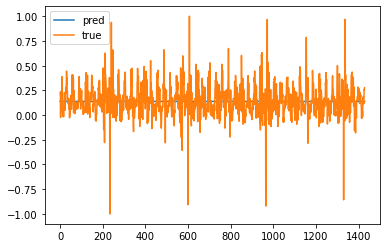

In [473]:
plt.plot(
    predy[:, 0, 0],
    label='pred'
)

plt.plot(
    valy[:, 0, 0],
    label='true'
)

plt.legend()

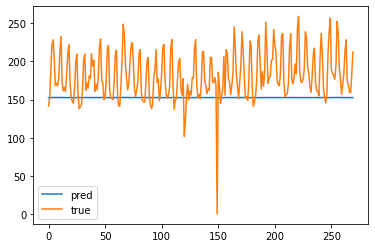

In [110]:
plt.plot(
    np.sum(predy[:, 0, :], axis=1),
    label='pred'
)

plt.plot(
    np.sum(valy[:, 0, :], axis=1),
    label='true'
)

plt.legend()